In [1]:
import numpy as np
import matplotlib.pyplot as plt
RNG = np.random.default_rng(seed=42)

Incompressible Navier-Stokes:

$$\begin{align*}
&\nabla \cdot \mathbf{u} = 0,\\
&\frac{\partial \mathbf{u}}{\partial t} = -(\mathbf{u}\cdot\nabla)\mathbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f} .
\end{align*}$$

# Discretization of Fields

The spatial domain will be a rectangular grid split into $N_y$ times $N_x$ cells with each cell centrally associated with a pressure value $(p)_{ij}$.

Each cell will be associated with in-coming and out-going velocities on both x and y axes: 
$$(u_x)_{i,j}, (u_x)_{i,j+1}, (u_y)_{i,j}, (u_y)_{i+1,j}.$$

## Staggered Grid and Boundary Convention and Index Form Loop for This Prototype

Neumann boundary conditions which act as such that pressure and velocity finite differences near boundaries are 0. That results in the boundaries acting as walls. Boundaries are set to the of the rectangle as well as to the edges of objects (a ball) that are mapped to lie in the center of the domain above source of dye.

Domain consists of $N_y \times N_x$ cells with equal spacings $\Delta x = \Delta y = h$ for both axes and pressure values $(p)_{i,j}$ that are in the center of every $(i,j)$-th cell. The values of $i$ correspond to the y coordinates $y_i = ih$ and j values correspond to x-coordinates $x_i = jh$ that correspond to the coordinates of center cell-s. The cell grid is staggered with respect to the velocity fields horizontal: $(u_x)_{i,j}$, vertical: $(u_y)_{i,j}$ values such that the positive values of $(u_x)_{i,j}, (u_y)_{i,j}$ correspond to the horizontal and vertical in-flow into the $(i,j)$-th cell and velocity field values $(u_x)_{i,j+1}, (u_y)_{i+1,j}$ correspond to the out-flow from the $(i,j)$-th cell through the right edge and bottom edge, respectively.

During the simulation loop, firstly an external force is applied to velocity on each cell's face.

Secondly, semi-Lagrangian advection flow for this type of setup is applied

Thirdly, diffusion of velocities is applied by solving the diffusion equation

$$\frac{\partial \vec{u_2}}{\partial t} = \nu \nabla^2 \vec{u_2}$$

via implicit method that uses bacward differences and result in equation 
$$(I-\nu \Delta t \nabla^2)\vec{u}_3 = \vec{u}_2$$

Finally, the pressure gradient 

$$\frac{\partial \vec{u}_3}{\partial t} = -\frac{\nabla^2 p}{\rho}$$

is applied. Pressure is not known beforehand, but it can be implicitly derived by enforcing the zero-divergence condition
**TODO**

In [ ]:
# Fluid grid initialization for velocities, 
class FluidGridInit:
    def __init__(self, cell_count_x, cell_count_y, h):
        # number of cells in both direction on a rectangular grid
        self.Nx = cell_count_x
        self.Ny = cell_count_y
        self.h = h # "infinitesimal" value dx = dy = h

        # initialize velocity fields
        self.u_x = np.zeros((self.Ny, self.Nx + 1), dtype=float)
        self.u_y = np.zeros((self.Ny+1, self.Nx), dtype=float)


        # initialize position matrices that coincide with the centers of cells
        x_s = np.linspace(0, (cell_count_x-1), cell_count_x, dtype=np.int32)
        y_s = np.linspace(0, (cell_count_y-1), cell_count_y, dtype=np.int32)

        #index matrices for velocities
        u_x_s = np.arange(0, self.Nx + 1, dtype=np.int32)
        u_y_s = np.arange(0, self.Ny + 1, dtype=np.int32)

        #u_x and u_y indice arrays
        self.u_x_indices_x, self.u_x_indices_y = np.meshgrid(u_x_s, y_s)
        self.u_y_indices_x, self.u_y_indices_y = np.meshgrid(x_s, u_y_s)

        # x-and-y-indices
        self.x_indices, self.y_indices = np.meshgrid(x_s, y_s)
        # x-and-y-coords
        self.x_coords, self.y_coords = np.meshgrid(x_s*h, y_s*h)

        # initialize scalar fields
        self.mask = np.zeros((self.Ny, self.Nx), dtype = bool)
        self.pressure = np.zeros((self.Ny, self.Nx))

    #return edge velocities of a cell
    def CellEdgeVelocities(self, i, j):
        return self.u_y[i,j], self.u_y[i+1,j], self.u_x[i,j], self.u_x[i,j+1] 

    def InitEdgeBoundaries(self, up, down, left, right):
            if up:
                self.mask[-1, :] = True
                self.u_y[-1, :] = 0
            if down:
                self.mask[0, :] = True
                self.u_y[0, :] = 0
            if left:
                self.mask[:, 0] = True
                self.u_x[:, 0] = 0
            if right:
                self.mask[:, -1] = True
                self.u_x[:, -1] = 0
    def ApplyBoundariesOnVelocities(self):
        for i in range(self.Ny):
              for j in range(self.Nx):
                   if self.mask[i,j] == True:
                        self.u_y[i,j] = 0
                        self.u_y[i+1,j] = 0
                        self.u_x[i,j] = 0
                        self.u_x[i,j+1] = 0
    def StandardMask(self):
        self.InitEdgeBoundaries(True, True, True, True)
        self.mask[self.Ny//2-self.Ny//10:self.Ny//2+self.Ny//10, self.Nx//2-self.Nx//10:self.Nx//2+self.Nx//6] = True

class FluidOperations(FluidGridInit):
    def __init__(self, Nx, Ny, h, delta_time):
        # Initialize parent class
        super().__init__(Nx, Ny, h)
        self.dt = delta_time
    
    def Divergence(self):
        div = np.zeros((self.Ny, self.Nx))
        hinv = 1/self.h
        for i in range(self.Ny):
            for j in range(self.Nx):
                div[i,j] = hinv * (
                    self.u_x[i, j+1] - self.u_x[i, j] +
                    self.u_y[i+1, j] - self.u_y[i, j]
                )
        return div

    def AddForce(self, fx, fy):
        self.u_x[:, :] += fx * self.dt
        self.u_y[:, :] += fy * self.dt
        self.ApplyBoundariesOnVelocities()
    
    def CenterVelocityDirections(self):
        u = np.zeros((self.Ny, self.Nx, 2))
        for i in range(self.Ny):
            for j in range(self.Nx):
                u[i,j] = 0.5 * np.array([self.u_x[i,j] + self.u_x[i,j+1], self.u_y[i+1,j] + self.u_y[i,j]])
        return u
                
    def CenterVelocityMagnitudes(self):
        u = np.zeros((self.Ny, self.Nx))
        for i in range(self.Ny):
            for j in range(self.Nx):
                u[i,j] = 0.25 * ((self.u_x[i,j] + self.u_x[i,j+1])**2 + (self.u_y[i+1,j] + self.u_y[i,j])**2)
        return u
    
    # pressure gradient across edges
    def PressureGradient(self):
        dpdx = np.zeros_like(self.u_x)
        dpdy = np.zeros_like(self.u_y)

        for i in range(self.Ny):
            for j in range(1, self.Nx):
                left_solid = self.mask[i, j-1] if j-1 >= 0 else True
                right_solid = self.mask[i, j] if j < self.Nx else True
                
                if not left_solid and not right_solid:
                    dpdx[i, j] = (1/self.h) * (self.pressure[i, j] - self.pressure[i, j-1])

        for i in range(1, self.Ny):
            for j in range(self.Nx):
                bottom_solid = self.mask[i-1, j] if i-1 >= 0 else True
                top_solid = self.mask[i, j] if i < self.Ny else True
                
                if not bottom_solid and not top_solid:
                    dpdy[i, j] = (1/self.h) * (self.pressure[i, j] - self.pressure[i-1, j])
        return dpdx, dpdy

    #takes current pressure, calculates its gradients and applies it as a force field on velocities
    def ApplyPressureGradient(self, clear_pressure : bool = True):
        dpdx, dpdy = self.PressureGradient()
        self.AddForce(-dpdx, -dpdy)
        if clear_pressure == True: self.pressure = np.zeros_like(self.pressure)

    #estimate the divergence clearance success as the mean of the absolute divergences
    def DivClearanceEstimate(self):
        return np.mean(np.abs(self.Divergence()))
    
    #pretty self-explanatory :)
    def WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically(self):
        u_x = self.u_x.copy()
        u_y = self.u_y.copy()

        #calculate the pressure gradient from class's global pressure value which was updated after method loop
        p_x,p_y= self.PressureGradient()

        #add force to velocity copies
        u_x[:, :] -= p_x * self.dt
        u_y[:, :] -= p_y * self.dt

        #calculate velocity copies' divergence
        div = np.zeros((self.Ny, self.Nx))
        hinv = 1/self.h
        for i in range(self.Ny):
            for j in range(self.Nx):
                div[i,j] = hinv * (
                    u_x[i, j+1] - u_x[i, j] +
                    u_y[i+1, j] - u_y[i, j]
                )
        #calculate and return its absoultes' mean
        return np.mean(np.abs(div))

    #estimates a Poisson solve method's sufficient amount of iterations until desired convergence
    def ToleranceTest(self, Method, tol = 0.4, max_iter = 10000):
        n = 0
        estimates = np.zeros(max_iter+1)
        pressures = np.zeros((max_iter+1, self.Ny, self.Nx))

        div = self.DivClearanceEstimate()
        estimates[n] = div
        pressures[n] = self.pressure
        while n < max_iter-2 and div > tol:
            Method(1)
            #applies the pressure gradient
            # without zeroing pressure so that the method doesn't start with 0-pressure with each iteration
            # AND without updating so that it wouldn't break the RHS (smh i didn't realize it earlier)
            div = self.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically()
            n+=1
            estimates[n-1] = div
            pressures[n-1] = self.pressure
        return estimates[:n], pressures[:n]
    
    def InitRandomVelocities(self, seed=np.random.default_rng(42)):
        self.u_x = seed.random(self.u_x.shape)-0.5
        self.u_y = seed.random(self.u_y.shape)-0.5
        #preserve boundary conditions
        self.ApplyBoundariesOnVelocities()

class JacobiCFD(FluidOperations):
    def __init__(self, Nx, Ny, h, delta_time):
        # Initialize parent class
        super().__init__(Nx, Ny, h, delta_time)

    #solves for hopefully divergence-free pressure and saves it into the class's pressure
    def JacobiSolve(self, iterations):
        p = self.pressure.copy()
        w = self.h**2/self.dt
        divu = self.Divergence()
        p_next = np.zeros_like(p)
        for _ in range(iterations):
            for i in range(1, self.Ny-1):
                for j in range(1, self.Nx-1):
                    if self.mask[i,j]:
                        continue
                    denom = 0 #i.e number of neighbors
                    denom += 1 if not self.mask[i,j+1] else 0
                    denom += 1 if not self.mask[i,j-1] else 0
                    denom += 1 if not self.mask[i+1,j] else 0
                    denom += 1 if not self.mask[i-1,j] else 0

                    p_next[i,j] = (1/denom) * (p[i,j+1] + p[i,j-1] + p[i+1,j] + p[i-1,j] - w * divu[i,j])
            p = p_next.copy()
        self.pressure = p.copy()

#Gauss Seidel = Jacobi with updated neighboring pressures each iteration step 
class GaussSeidelCFD(FluidOperations):
    def __init__(self, Nx, Ny, h, delta_time):
        # Initialize parent class
        super().__init__(Nx, Ny, h, delta_time)

    #solves for hopefully divergence-free pressure and saves it into the class's pressure
    def GaussSeidelSolve(self, iterations):
        w = self.h**2/self.dt
        divu = self.Divergence()
        p_next = self.pressure.copy()
        for _ in range(iterations):
            for i in range(1, self.Ny-1):
                for j in range(1, self.Nx-1):
                    if self.mask[i,j]:
                        continue
                    denom = 0 #i.e number of neighbors
                    denom += 1 if not self.mask[i,j+1] else 0
                    denom += 1 if not self.mask[i,j-1] else 0
                    denom += 1 if not self.mask[i+1,j] else 0
                    denom += 1 if not self.mask[i-1,j] else 0

                    p_next[i,j] = (1/denom) * (p_next[i,j+1] + p_next[i,j-1] + p_next[i+1,j] + p_next[i-1,j] - w * divu[i,j])
        self.pressure = p_next.copy()

#Successive Over-Relaxation = Gauss-Seidel with a magic number
class SuccessiveOverRelaxationCFD(FluidOperations):
    def __init__(self, Nx, Ny, h, delta_time):
        # Initialize parent class
        super().__init__(Nx, Ny, h, delta_time)
        rhoGS = (np.cos(np.pi/self.Ny) + np.cos(np.pi/self.Nx))/2
        omega = 2/(1+np.sqrt(1-rhoGS**2))
        self.MagicNumber = omega


    #solves for hopefully divergence-free pressure and saves it into the class's pressure
    def SOR_Solve(self, iterations):
        omega = self.MagicNumber
        w = self.h**2/self.dt
        divu = self.Divergence()
        p_next = self.pressure.copy()  # will update in place
        
        for _ in range(iterations):
            for i in range(1, self.Ny-1):
                for j in range(1, self.Nx-1):
                    if self.mask[i,j]:
                        continue
                    
                    sum_neighbors = 0
                    denom = 0
                    if not self.mask[i,j+1]: 
                        sum_neighbors += p_next[i,j+1]
                        denom += 1
                    if not self.mask[i,j-1]: 
                        sum_neighbors += p_next[i,j-1]
                        denom += 1
                    if not self.mask[i+1,j]: 
                        sum_neighbors += p_next[i+1,j]
                        denom += 1
                    if not self.mask[i-1,j]: 
                        sum_neighbors += p_next[i-1,j]
                        denom += 1
                    
                    if denom > 0:
                        p_GS = (1/denom) * (sum_neighbors - w * divu[i,j])
                        p_next[i,j] = (1 - omega) * (1/denom) * p_next[i,j] + omega * p_GS
        
        self.pressure = p_next.copy()
           

#TODO: RedBlackGS, RedBlackSOR, MultiGrid?

In [22]:
# discrete "infinitesimal" parameters for spacing and time
h = 0.1 # meters
dt = 0.01 # seconds


#N_x = N_y = 100 #
#setting the discrete dimensions of the domain
N_y1 = 100
N_x1 = 100

m_JacobiCFD = JacobiCFD(N_x1, N_y1, h, dt)
m_GaussSeidelCFD = GaussSeidelCFD(N_x1, N_y1, h, dt)
m_SORCFD = SuccessiveOverRelaxationCFD(N_x1, N_y1, h, dt)

u_x = m_JacobiCFD.u_x
u_y = m_JacobiCFD.u_y

u_x_indices_x1 = m_JacobiCFD.u_x_indices_x
u_x_indices_y1 = m_JacobiCFD.u_x_indices_y

u_y_indices_x1 =  m_JacobiCFD.u_y_indices_x
u_y_indices_y1 =  m_JacobiCFD.u_y_indices_y

x_indices1 = m_JacobiCFD.x_indices
y_indices1 = m_JacobiCFD.y_indices

x_coords1 = m_JacobiCFD.x_coords
y_coords1 = m_JacobiCFD.y_coords

[]

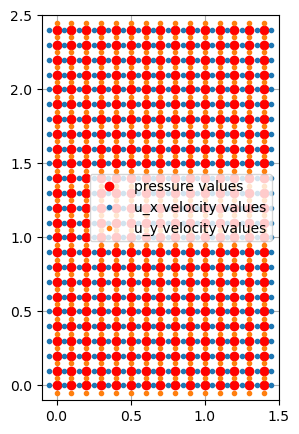

In [19]:
coordpairs1 = []

for i in range(N_y1):
    for j in range(N_x1):
        #print(x_coords1[i,j],y_coords1[i,j])
        coordpairs1.append( [x_coords1[i,j], y_coords1[i,j]])

u_x1_indexpairs = []
u_y1_indexpairs = []


for i in range(N_y1):
    for j in range(N_x1+1):
        u_x1_indexpairs.append( [u_x_indices_x1[i,j], u_x_indices_y1[i,j]] )

for i in range(N_y1+1):
    for j in range(N_x1):
        u_y1_indexpairs.append( [u_y_indices_x1[i,j], u_y_indices_y1[i,j]] )


u_y1_indexpairs = np.array(u_y1_indexpairs)
u_x1_indexpairs = np.array(u_x1_indexpairs)

coordpairs1 = np.array(coordpairs1)

#u_x1_indexpairs, u_y1_indexpairs

fig, ax = plt.subplots(figsize = (5,5))

plt.plot(coordpairs1.T[0],coordpairs1.T[1], 'ro', label = "pressure values")

plt.plot(u_x1_indexpairs.T[0]*h-1/2 *h, u_x1_indexpairs.T[1]*h, '.', label = "u_x velocity values")

plt.plot(u_y1_indexpairs.T[0]*h, u_y1_indexpairs.T[1]*h-1/2 *h, '.', label = "u_y velocity values")

ax.set_aspect("equal")

plt.xlim(-h,x_coords1.max()+h)
plt.ylim(-h,y_coords1.max()+h)
plt.grid()

plt.legend()

plt.plot()

[]

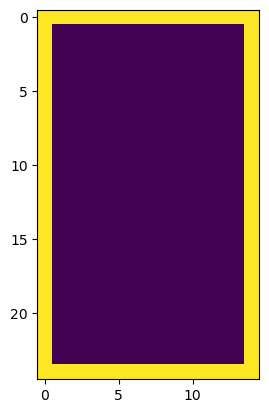

In [20]:
m_mask = m_JacobiCFD.mask
m_JacobiCFD.InitEdgeBoundaries(True,True,True,True)

plt.imshow(m_mask)
plt.plot()

## Adjust Boundaries

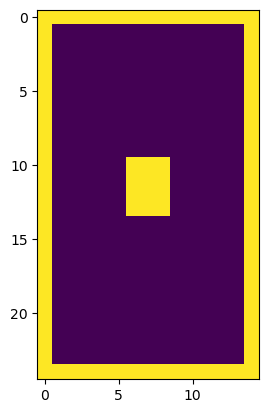

In [21]:
copy_mask = m_mask.copy()

copy_mask[N_y1//2-N_y1//10:N_y1//2+N_y1//10, N_x1//2-N_x1//10:N_x1//2+N_x1//6] = True

plt.imshow(copy_mask)
plt.show()

In [22]:
#set it to be equal to the FluidGrid-s mask
m_JacobiCFD.mask = copy_mask

## Initialize random velocities

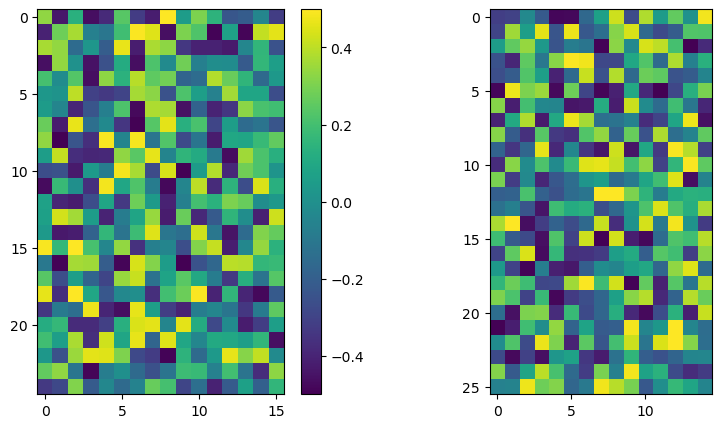

In [23]:
m_JacobiCFD.u_x = np.random.rand(*m_JacobiCFD.u_x.shape, ) -0.5
m_JacobiCFD.u_y = np.random.rand(*m_JacobiCFD.u_y.shape) - 0.5

fig,ax = plt.subplots(1,2, figsize=(10,5))

im0 = ax[0].imshow(m_JacobiCFD.u_x)
ax[1].imshow(m_JacobiCFD.u_y)
fig.colorbar(im0)
plt.show()

## Apply Boundary Conditions On Velocities

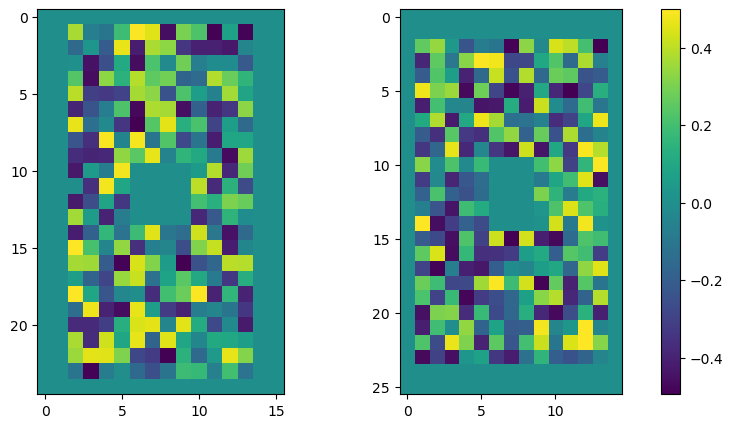

In [24]:
m_JacobiCFD.ApplyBoundariesOnVelocities()

fig,ax = plt.subplots(1,2, figsize=(10,5))

im0 = ax[0].imshow(m_JacobiCFD.u_x)
im1 = ax[1].imshow(m_JacobiCFD.u_y)
fig.colorbar(im0, ax = ax)
plt.show()

# Finite Difference Operators

## Plot Divergence

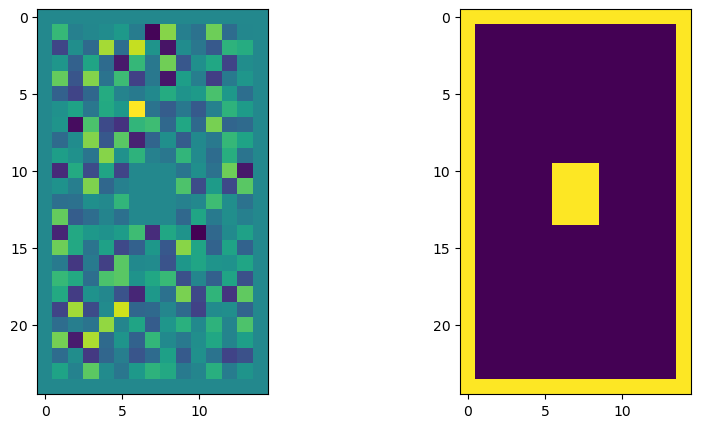

In [25]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(m_JacobiCFD.Divergence())
ax[1].imshow(m_JacobiCFD.mask)
plt.show()

In [26]:
m_JacobiCFD.Divergence()[N_y1//2-N_y1//10:N_y1//2+N_y1//10, N_x1//2-N_x1//10:N_x1//2+N_x1//6],\
m_JacobiCFD.mask[N_y1//2-N_y1//10:N_y1//2+N_y1//10, N_x1//2-N_x1//10:N_x1//2+N_x1//6]

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

## Plot Velocity Magnitudes

C:\Users\ander\AppData\Local\Temp\ipykernel_31984\3486632735.py:6: UserWarning: Adding colorbar to a different Figure <Figure size 1000x500 with 3 Axes> than <Figure size 1000x500 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(im1, ax = ax)


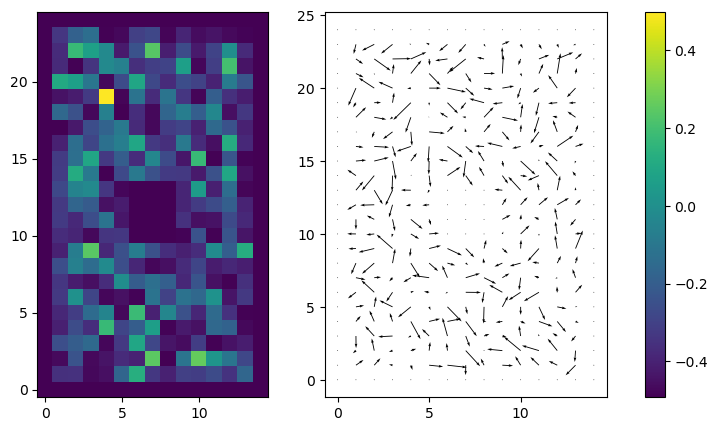

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

im0 = ax[0].imshow(m_JacobiCFD.CenterVelocityMagnitudes(), origin = "lower")
ax[1].quiver(m_JacobiCFD.x_indices, m_JacobiCFD.y_indices,
              m_JacobiCFD.CenterVelocityDirections()[:,:,0], m_JacobiCFD.CenterVelocityDirections()[:,:,1])
fig.colorbar(im1, ax = ax)
plt.show()

## Add Forces

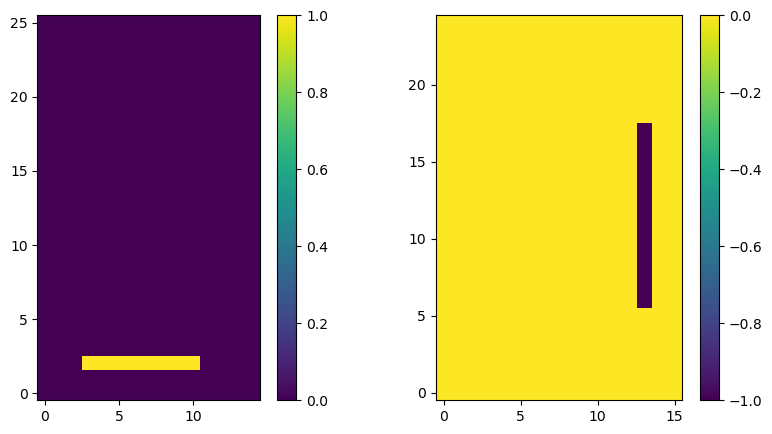

In [28]:
#define force field to be similar shaped as the grid of velocity corresponding components
f_y = np.zeros_like(m_JacobiCFD.u_y)
f_x = np.zeros_like(m_JacobiCFD.u_x)
f_y[2, N_x1//4:3*N_x1//4] = 1
f_x[N_y1//4:3*N_y1//4, -3] = -1

fig, ax = plt.subplots(1,2, figsize=(10,5))

im0 = ax[0].imshow(f_y, origin= "lower")
im1 = ax[1].imshow(f_x, origin = "lower")
fig.colorbar(im0, ax = ax[0])
fig.colorbar(im1, ax = ax[1])

plt.show()

In [29]:
save_u_x = m_JacobiCFD.u_x.copy()
save_u_y = m_JacobiCFD.u_y.copy()

In [30]:
for i in range(50): m_JacobiCFD.AddForce(f_x, f_y)

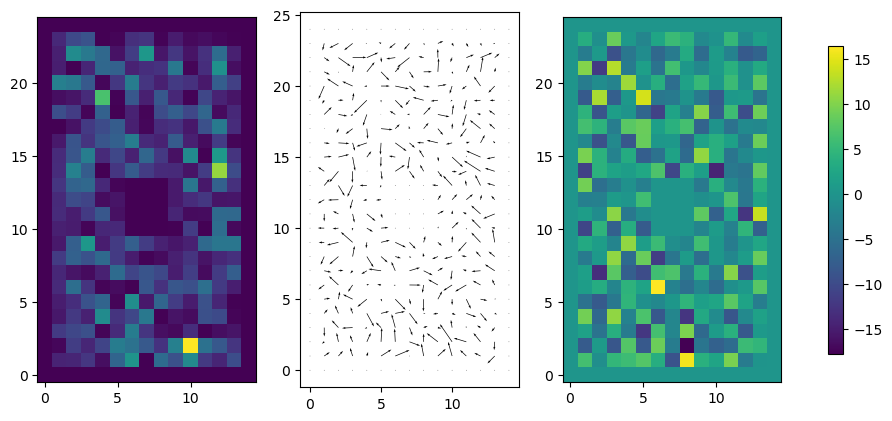

-1.4210854715202004e-17 5.220355615136662 16.42181613559164


In [33]:
fig, ax = plt.subplots(1,3, figsize=(12,8))

im0 = ax[0].imshow(m_JacobiCFD.CenterVelocityMagnitudes(), origin = "lower")
ax[1].quiver(m_JacobiCFD.x_indices, m_JacobiCFD.y_indices,
              m_JacobiCFD.CenterVelocityDirections()[:,:,0], m_JacobiCFD.CenterVelocityDirections()[:,:,1])

im2 = ax[2].imshow(m_JacobiCFD.Divergence(),origin = "lower")

for a in ax:
    a.set_aspect('equal')

#fig.colorbar(im0, ax = ax[0], orientation='horizontal')
#fig.colorbar(im2, ax = ax[2], orientation='horizontal')

fig.colorbar(im2, ax = ax, shrink = 0.5)

plt.show()

print(np.mean(m_JacobiCFD.Divergence()), np.std(m_JacobiCFD.Divergence()), np.max(m_JacobiCFD.Divergence()))

### Pressure Poisson and Divergence Clearance

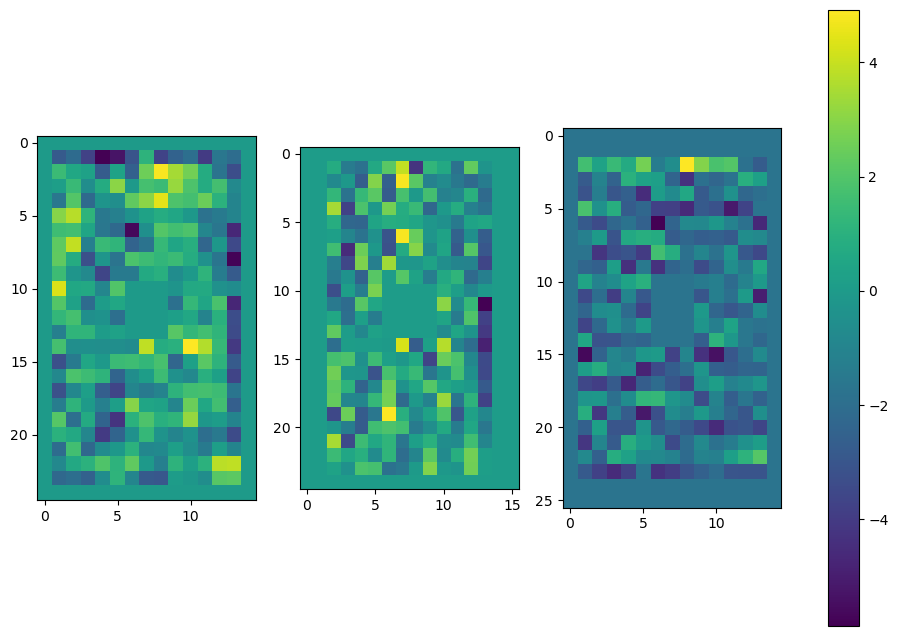

In [34]:
fig, ax = plt.subplots(1,3,figsize=(12,8))


m_JacobiCFD.JacobiSolve(10)

im0 = ax[0].imshow(m_JacobiCFD.pressure)
ax[1].imshow(m_JacobiCFD.PressureGradient()[0])
ax[2].imshow(m_JacobiCFD.PressureGradient()[1])

fig.colorbar(im0, ax = ax)
plt.show()

m_JacobiCFD.ApplyPressureGradient()

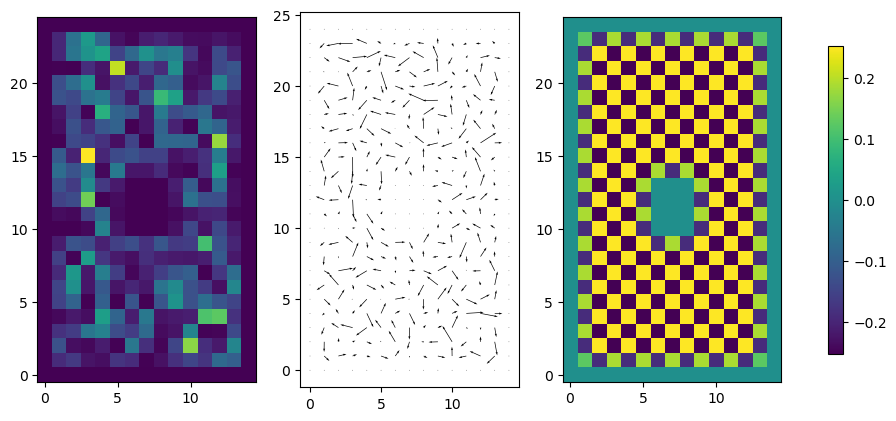

0.17878093316589927 0.2061264443460874 0.25251544232472556


In [35]:
m_JacobiCFD.JacobiSolve(10000)
m_JacobiCFD.ApplyPressureGradient()
fig, ax = plt.subplots(1,3, figsize=(12,8))

im0 = ax[0].imshow(m_JacobiCFD.CenterVelocityMagnitudes(), origin = "lower")
ax[1].quiver(m_JacobiCFD.x_indices, m_JacobiCFD.y_indices,
              m_JacobiCFD.CenterVelocityDirections()[:,:,0], m_JacobiCFD.CenterVelocityDirections()[:,:,1])

im2 = ax[2].imshow(m_JacobiCFD.Divergence(),origin = "lower")

for a in ax:
    a.set_aspect('equal')

#fig.colorbar(im0, ax = ax[0], orientation='horizontal')
fig.colorbar(im2, ax = ax, shrink = 0.5)


plt.show()

print(np.mean(np.abs(m_JacobiCFD.Divergence())), np.std(m_JacobiCFD.Divergence()), np.max(m_JacobiCFD.Divergence()))

In [4]:
def DrawVelocityMagArrowsDiv(MyClass):
    fig, ax = plt.subplots(1,3, figsize=(12,8))

    im0 = ax[0].imshow(MyClass.CenterVelocityMagnitudes(), origin = "lower")
    ax[1].quiver(MyClass.x_indices, MyClass.y_indices,
              MyClass.CenterVelocityDirections()[:,:,0], MyClass.CenterVelocityDirections()[:,:,1])

    im2 = ax[2].imshow(MyClass.Divergence(),origin = "lower")

    for a in ax:
        a.set_aspect('equal')

    #fig.colorbar(im0, ax = ax[0], orientation='horizontal')
    fig.colorbar(im2, ax = ax, shrink = 0.5)
    plt.show()

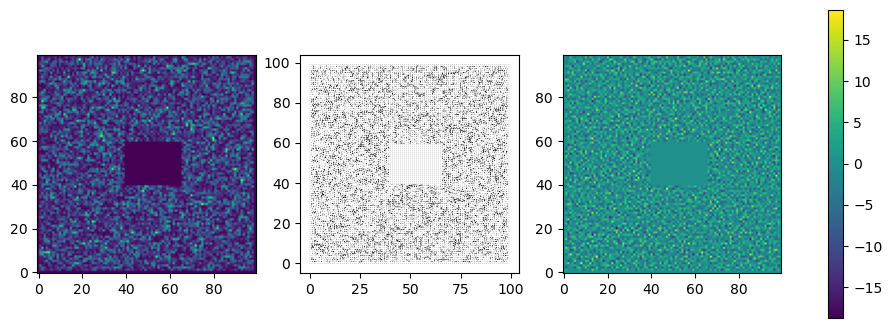

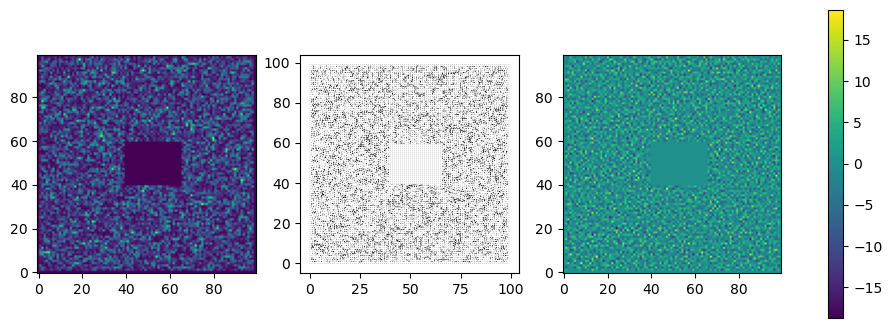

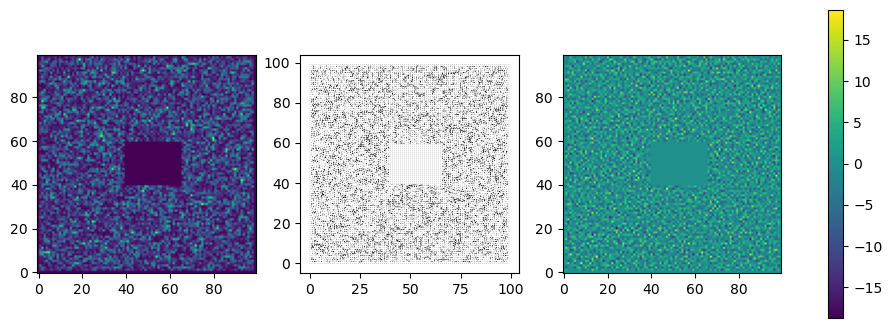

In [23]:
m_JacobiCFD.InitRandomVelocities(seed=np.random.default_rng(42))
m_JacobiCFD.StandardMask()
m_JacobiCFD.ApplyBoundariesOnVelocities()
m_JacobiCFD.pressure = np.zeros_like(m_JacobiCFD.pressure)

DrawVelocityMagArrowsDiv(m_JacobiCFD)

m_GaussSeidelCFD.InitRandomVelocities(seed=np.random.default_rng(42))
m_GaussSeidelCFD.StandardMask()
m_GaussSeidelCFD.ApplyBoundariesOnVelocities()
m_GaussSeidelCFD.pressure = np.zeros_like(m_JacobiCFD.pressure)


DrawVelocityMagArrowsDiv(m_GaussSeidelCFD)


m_SORCFD.InitRandomVelocities(seed=np.random.default_rng(42))
m_SORCFD.StandardMask()
m_SORCFD.ApplyBoundariesOnVelocities()
m_SORCFD.pressure = np.zeros_like(m_JacobiCFD.pressure)

DrawVelocityMagArrowsDiv(m_SORCFD)

In [6]:
#teen tolerantsitesti käsitsi, sest olen nördinud klassi-sisese funktsiooni mittetöötamise pärast D:

divJ = []

divJ.append(m_JacobiCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())
divJ


while divJ[len(divJ)-1] > 0.2 and len(divJ) < 5000:
    m_JacobiCFD.JacobiSolve(1)
    divJ.append(m_JacobiCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())

divJ = np.array(divJ)

KeyboardInterrupt: 

In [24]:
#teen tolerantsitesti käsitsi, sest olen nördinud klassi-sisese funktsiooni mittetöötamise pärast D:

divGS = []

divGS.append(m_GaussSeidelCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())
divGS


while divGS[len(divGS)-1] > 0.1 and len(divGS) < 5000:
    m_GaussSeidelCFD.GaussSeidelSolve(1)
    divGS.append(m_GaussSeidelCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())

divGS = np.array(divGS)

In [25]:
#teen tolerantsitesti käsitsi, sest olen nördinud klassi-sisese funktsiooni mittetöötamise pärast D:

divSOR = []

divSOR.append(m_SORCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())
divSOR


while divSOR[len(divSOR)-1] > 0.1 and len(divSOR) < 5000:
    m_SORCFD.SOR_Solve(1)
    divSOR.append(m_SORCFD.WhatWouldTheDivClearanceEstimateBeRightNowIfPressureGradientWasAppliedRightNowHypothetically())

divSOR = np.array(divSOR)

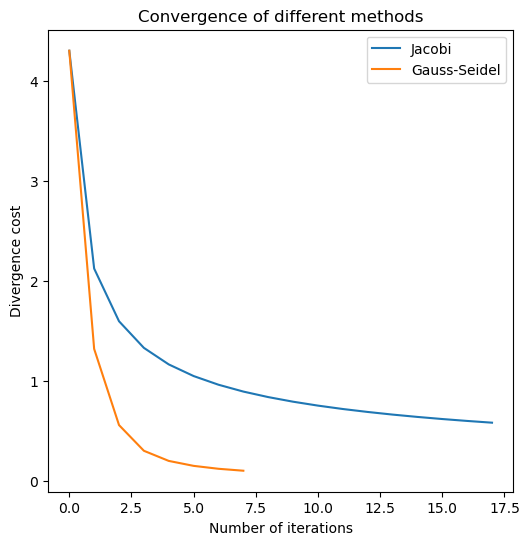

In [16]:
plt.figure(figsize=(6,6))
plt.title("Convergence of different methods")
plt.plot(divJ, label = "Jacobi")
plt.plot(divGS, label = "Gauss-Seidel")
#plt.plot(divSOR, label = "SOR")
plt.ylabel("Divergence cost")
plt.xlabel("Number of iterations")
plt.legend()
plt.show()